In [1]:
%cd ~/Desktop/Paris_Cite/Year2/Projet_Long/PoincareMSA

#Load outside module dependencies
import os
import numpy as np
import pandas as pd
import subprocess
import json
import warnings
warnings.filterwarnings('ignore')
import scipy

from sklearn.manifold import MDS
from sklearn.manifold import TSNE
from sklearn.decomposition import KernelPCA

from sklearn.metrics import pairwise_distances
from scipy.spatial.distance import cosine
import plotly.express as px
import plotly.graph_objs as go
import umap

#Import local functions
from scripts.visualize_projection.pplots_new import read_embeddings, plot_embedding, plot_embedding_interactive, rotate, get_colors
from scripts.build_poincare_map.data import construct_tensor_from_embedding, prepare_embedding_data, prepare_data
%matplotlib inline

from scripts.build_poincare_map.poincare_maps import *
from scripts.build_poincare_map.embedding_quality_score import *

/Users/gabrielduval/Desktop/Paris_Cite/Year2/Projet_Long/PoincareMSA


In [2]:
#from scripts.build_poincare_map.kmedoids import *
from sklearn import metrics
from sklearn.cluster import *

def get_scores(t_labels, labels):
    ARS = metrics.adjusted_rand_score(t_labels, labels)
    FMS = metrics.fowlkes_mallows_score(t_labels, labels)
    
    return ARS, FMS

def detect_cluster(D, n_clusters=2, clustering_name='spectral', k=5, class_exclude = "OTHER"): #distances='Poincaré',
    if clustering_name == 'spectral':
        similarity = np.exp(-D**2)
        clustering = SpectralClustering(n_clusters=n_clusters, eigen_solver='arpack', 
                                        affinity='precomputed', n_neighbors=k).fit(similarity)
        labels = clustering.labels_
    elif clustering_name == 'kmedoids':
        clustering = kMedoids(D, n_clusters, tmax=10000)
        labels = clustering
    else:
        #clustering = AgglomerativeClustering(linkage='average', n_clusters=n_clusters, 
        #                                     affinity='precomputed').fit(D)
        clustering = AgglomerativeClustering(linkage='average', n_clusters=n_clusters).fit(D)
        labels = clustering.labels_
            
    return labels

Labels and number of clusters:

In [3]:
knn = 5
gamma = 2
sigma = 1
cospca = 0
batchs = 4
epochs = 1000
seed = 0

# Load path
path_annotation = "examples/thioredoxins/thioredoxin_annotation.csv"

# Load mfasta
out_name_mfasta = "results/thioredoxins/with_mfasta"
path_embedding_mfasta = f"{out_name_mfasta}/PM{knn:1.0f}sigma={sigma:2.2f}gamma={gamma:2.2f}cosinepca={cospca:1.0f}_seed{seed:1.0f}.csv"
df_embedding_mfasta = read_embeddings(path_embedding_mfasta, path_annotation, withroot=False)
df_embedding_mfasta.replace("Other", "OTHER")
print(df_embedding_mfasta['Family'].unique())

# Load embeddings
out_name_embed = "results/thioredoxins/with_plm_embeddings"
path_embedding_embed = f"{out_name_embed}/PM{knn:1.0f}sigma={sigma:2.2f}gamma={gamma:2.2f}cosinepca={cospca:1.0f}_seed{seed:1.0f}.csv"
df_embedding_embed = read_embeddings(path_embedding_embed, path_annotation, withroot=False)
df_embedding_embed.replace("Other", "OTHER")
print(df_embedding_embed['Family'].unique())


['LBCA' 'LACA' 'AECA' 'LGPCA' 'LECA' 'LPBCA' 'LAFCA' 'Metazoa' 'Fungi'
 'Choanoflagellata' 'Amoebozoa' 'Viridiplantae' 'Alveolata' 'Sar'
 'Euryarchaeota' 'Crenarchaeota' 'Firmicutes' 'Chlamydiae' 'Chlorobi'
 'Bacteroidetes' 'Planctomycetes' 'Actinobacteria' 'Cyanobacteria'
 'Deinococcus-Thermus' 'Chloroflexi' 'Aquificae' 'Proteobacteria'
 'Acidobacteria']
['LBCA' 'LACA' 'AECA' 'LGPCA' 'LECA' 'LPBCA' 'LAFCA' 'Metazoa' 'Fungi'
 'Choanoflagellata' 'Amoebozoa' 'Viridiplantae' 'Alveolata' 'Sar'
 'Euryarchaeota' 'Crenarchaeota' 'Firmicutes' 'Chlamydiae' 'Chlorobi'
 'Bacteroidetes' 'Planctomycetes' 'Actinobacteria' 'Cyanobacteria'
 'Deinococcus-Thermus' 'Chloroflexi' 'Aquificae' 'Proteobacteria'
 'Acidobacteria']


In [4]:
# Load mfasta model

poincare_coord_mfasta = pd.read_csv(path_embedding_mfasta, sep=',').sort_values(by=["proteins_id"])
poincare_coord_mfasta = poincare_coord_mfasta.values[:,:2]
# Additional step to convert normal float to numpy float
poincare_coord_mfasta = np.array(poincare_coord_mfasta, dtype = np.float64)
model_mfasta = PoincareMaps(poincare_coord_mfasta)
model_mfasta.get_distances()

# Load embedding model

poincare_coord_embed = pd.read_csv(path_embedding_embed, sep=',').sort_values(by=["proteins_id"])
poincare_coord_embed = poincare_coord_embed.values[:,:2]
# Additional step to convert normal float to numpy float
poincare_coord_embed = np.array(poincare_coord_embed, dtype = np.float64)
model_embed = PoincareMaps(poincare_coord_embed)
model_embed.get_distances()


# Comparison of different scores for Poincaré vs other methods

Prepare feature file for other methods.

In [5]:
# VERY IMPORTANT - Features must be loaded in sorted python order, because the read_embedding
# function sorts the results csv based on protein id. 
def construct_tensor_from_embedding(fpath, option = 'mean'):
    '''Same function as construct_tensor, but adapted for embeddings
    
    Args
    ---
    fpath : str
        Path to embedding file; these are usually stored in .pt format
    option : str
        How should the embeddings be reduced ?

    Returns
    ---
    tensor 
    '''
    fixed_embedding = torch.load(fpath)['embedding']
    fixed_embedding = np.mean(fixed_embedding, axis = 0)
    return fixed_embedding


# General variables
fasta_files = 'examples/thioredoxins/thioredoxins_data'

n_proteins = df_embedding_mfasta.shape[0]
x = np.array(np.loadtxt(fasta_files + "/fasta0.9/1.aamtx").reshape(-1))
len_prot = len(x)


# For mfasta poincare
features_mfasta = np.zeros([n_proteins, len_prot])

for i in range(n_proteins):
    local = np.array(np.loadtxt(fasta_files + "/fasta0.9/" + str(i+1) + ".aamtx").reshape(-1))
    features_mfasta[i,:] = local
print(features_mfasta.shape)


# For embedding poincare
embed_files = 'embeddings/ankh_base_thioredoxins'
ankh_base_dimension = 768

features_embed = np.zeros([n_proteins, ankh_base_dimension])

for i in range(n_proteins):
    local = construct_tensor_from_embedding(f'{embed_files}/{i + 1}.pt')
    features_embed[i,:] = local
print(features_embed.shape)

(210, 7800)
(210, 768)


Calculate original distances:

In [6]:
# Mfasta
D_raw_mfasta = pairwise_distances(features_mfasta, metric="cosine")
print(D_raw_mfasta.shape)

print(df_embedding_mfasta['proteins_id'])

# Embeddings
D_raw_embed = pairwise_distances(features_embed, metric="cosine")
print(D_raw_embed.shape)

print(df_embedding_embed['proteins_id'])

(210, 210)
proteins_id
1        1
2        2
3        3
4        4
5        5
      ... 
206    206
207    207
208    208
209    209
210    210
Name: proteins_id, Length: 210, dtype: object
(210, 210)
proteins_id
1        1
2        2
3        3
4        4
5        5
      ... 
206    206
207    207
208    208
209    209
210    210
Name: proteins_id, Length: 210, dtype: object


# SET PARAMETERS

In [7]:
df_results_clust = pd.DataFrame()
df_results_proj = pd.DataFrame()

In [8]:
k_neigh = knn

# by names/family
true_col = "Family" # "short_species"# 
other =  -1 

# Remove all proteins with no annotation ?
remove_others = False

# Remove all unique proteins ?
remove_outliers = False

# Determine expected number of classes from the number of labels
if remove_outliers:
    no_outliers = df_embedding_mfasta[true_col].duplicated(keep=False)
    expected_nc = df_embedding_mfasta[no_outliers][true_col].unique().size
else:
    expected_nc = df_embedding_mfasta[true_col].unique().size

nc = expected_nc

print("Number of expected classes: ", expected_nc)

Number of expected classes:  28


In [ ]:
# Construction of custom color palette 
# colour_json = 'examples/wayland_datasets/phosphatase/phosphatase_colors.json'
# with open(colour_json, 'r') as file:
#     phosphatase_cols = json.load(file)

# ALL TOGETHER

## Evaluate clustering - embedding vs other methods using embedding

In [9]:
cname = 'agglomerative'
setting = "manifold" # "global" #
#out_name = 'results/thioredoxins/with_mfasta' 
#out_name = "results/thioredoxins/with_plm_embeddings"

for seed in range(5):
    # read poincare and annotations
    path_embedding = f"{out_name_embed}/PM{knn:1.0f}sigma={sigma:2.2f}gamma={gamma:2.2f}cosinepca={cospca:1.0f}_seed{seed:1.0f}.csv"
    df_embedding = read_embeddings(path_embedding, path_annotation, withroot=False)
    df_embedding.replace("Other", "OTHER")
    # calculate poincare distances
    poincare_coord = df_embedding[["pm1","pm2"]]
    poincare_coord = poincare_coord.values
    #print(poincare_coord)
    model = PoincareMaps(poincare_coord)
    model.get_distances()
    # poincare scores
    clusters = detect_cluster(model.distances, n_clusters=nc, clustering_name=cname)
    df_embedding["clust_poincare_w_embed"] = clusters
    df_embedding["clust_poincare_w_embed"] = df_embedding["clust_poincare_w_embed"].astype("string")
    # MDS scores
    X_cosine = pairwise_distances(features_embed,metric='cosine')
    X_mds = MDS(metric=True,dissimilarity='precomputed', random_state = seed).fit_transform(X_cosine)
    df_embedding["x1_mds"] = X_mds[:,0]
    df_embedding["x2_mds"] = X_mds[:,1]
    D = pairwise_distances(X_mds)
    clusters = detect_cluster(D, n_clusters=nc, clustering_name=cname)
    df_embedding["clust_mds"] = clusters
    df_embedding["clust_mds"] = df_embedding["clust_mds"].astype("string")
    # tSNE scores
    X_tsne = TSNE(random_state = seed, metric = "cosine", perplexity=k_neigh).fit_transform(features_embed)
    df_embedding["x1_tsne"] = X_tsne[:,0]
    df_embedding["x2_tsne"] = X_tsne[:,1]
    D = pairwise_distances(X_tsne)
    clusters = detect_cluster(D, n_clusters=nc, clustering_name=cname)
    df_embedding["clust_tsne"] = clusters
    df_embedding["clust_tsne"] = df_embedding["clust_tsne"].astype("string")
    # UMAP scores
    X_umap = umap.UMAP(random_state = seed, metric = "cosine", n_neighbors = k_neigh).fit_transform(features_embed)
    df_embedding["x1_umap"] = X_umap[:,0]
    df_embedding["x2_umap"] = X_umap[:,1]
    D = pairwise_distances(X_umap)
    clusters = detect_cluster(D, n_clusters=nc, clustering_name=cname)
    df_embedding["clust_umap"] = clusters
    df_embedding["clust_umap"] = df_embedding["clust_umap"].astype("string")
    # PCA scores
    X_pca = KernelPCA(kernel='cosine', random_state = seed).fit_transform(features_embed)
    df_embedding["x1_pca"] = X_pca[:,0]
    df_embedding["x2_pca"] = X_pca[:,1]
    D = pairwise_distances(X_pca)
    clusters = detect_cluster(D, n_clusters=nc, clustering_name=cname)#, k=15)
    df_embedding["clust_pca"] = clusters
    df_embedding["clust_pca"] = df_embedding["clust_pca"].astype("string")
    
    # clustering
    if remove_outliers:
        df_noothers = df_embedding[no_outliers]
    if remove_others:
        df_noothers = df_noothers[df_embedding[true_col]!=other]
    if not remove_outliers and not remove_others:
        df_noothers = df_embedding
    
    for clust_meth in ["poincare_w_embed", "mds", "tsne", "umap", "pca"]:

        ARI, FMS = get_scores(df_noothers[true_col], df_noothers["clust_" + clust_meth])

        if clust_meth == "poincare_w_embed":
            D = model.distances
            Qlocal, Qglobal, Kmax, df_Q = get_quality_metrics(coord_high = features_embed, coord_low = model.coordinates, distance="poincare", setting=setting, k_neighbours=5)
        else:
            D = pairwise_distances(df_embedding.loc[:, "x1_"+clust_meth:"x2_"+clust_meth])
            Qlocal, Qglobal, Kmax, df_Q = get_quality_metrics(coord_high = features_embed, coord_low = df_embedding.loc[:, "x1_"+clust_meth:"x2_"+clust_meth], distance="euclidean", setting=setting, k_neighbours=5)

        corr = scipy.stats.spearmanr(D_raw_embed.ravel(), D.ravel(), axis = 0)
    
        df = pd.DataFrame({"method": [clust_meth], "seed": [seed], "nc": [nc], "true_col": [true_col], "ARI": [ARI], "FMS": [FMS]})
        df_results_clust = pd.concat([df_results_clust, df])
        
        # print(df_Q.Qnx.to_numpy())
        
        df = pd.DataFrame({"method": [clust_meth], "seed": [seed], "Qlocal": [Qlocal], "Qglobal": [Qglobal], "Kmax": [Kmax], "Qnx": [df_Q.Qnx.to_numpy()]})
        df_results_proj = pd.concat([df_results_proj, df])


#print(df_results)

Connecting 2
Connecting 2
Connecting 2
Connecting 2
Connecting 2
Connecting 2
Connecting 2
Connecting 2
Connecting 2
Connecting 2
Connecting 2
Connecting 2
Connecting 2
Connecting 2
Connecting 2
Connecting 2
Connecting 2
Connecting 2
Connecting 2
Connecting 2
Connecting 2
Connecting 2
Connecting 2
Connecting 2
Connecting 2


In [10]:
# Test composition of df_results_clust
#print(df_embedding.columns)
print(df_results_proj.head(10))

             method  seed    Qlocal   Qglobal  Kmax  \
0  poincare_w_embed     0  0.575891  0.835990    10   
0               mds     0  0.470352  0.809219    31   
0              tsne     0  0.732143  0.757622     1   
0              umap     0  0.532937  0.745691     3   
0               pca     0  0.469041  0.807028    36   
0  poincare_w_embed     1  0.572505  0.825200     9   
0               mds     1  0.479616  0.810525    32   
0              tsne     1  0.740476  0.772409     1   
0              umap     1  0.550622  0.783572     5   
0               pca     1  0.469041  0.807028    36   

                                                 Qnx  
0  [0.30952380952380953, 0.3976190476190476, 0.47...  
0  [0.14761904761904762, 0.24523809523809523, 0.2...  
0  [0.719047619047619, 0.7452380952380953, 0.6825...  
0  [0.37142857142857144, 0.5380952380952381, 0.59...  
0  [0.13333333333333333, 0.19047619047619047, 0.2...  
0  [0.3047619047619048, 0.4095238095238095, 0.504...  
0  [0.138

### Test FMS Scores

In [11]:
fig = px.strip(df_results_clust, x='method', y='FMS', color = "true_col")
fig.update_yaxes(range = [0,1])
fig.show()

# Need to add the original poincaré method

In [15]:
fig.write_html("FMS_phosphatase_test.html")

### Test QNX Scores

In [12]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [13]:
print(sns.color_palette(palette=None, n_colors=5).as_hex())
meth_palette = dict(zip(["poincare_w_embed", "mds", "tsne", "umap", "pca"], sns.color_palette(palette=None, n_colors=5).as_hex()))
print(meth_palette)

['#4c72b0', '#dd8452', '#55a868', '#c44e52', '#8172b3']
{'poincare_w_embed': '#4c72b0', 'mds': '#dd8452', 'tsne': '#55a868', 'umap': '#c44e52', 'pca': '#8172b3'}


poincare_w_embed 0.81, 0.01
mds 0.76, 0.00
tsne 0.77, 0.01
umap 0.77, 0.02
pca 0.75, 0.00


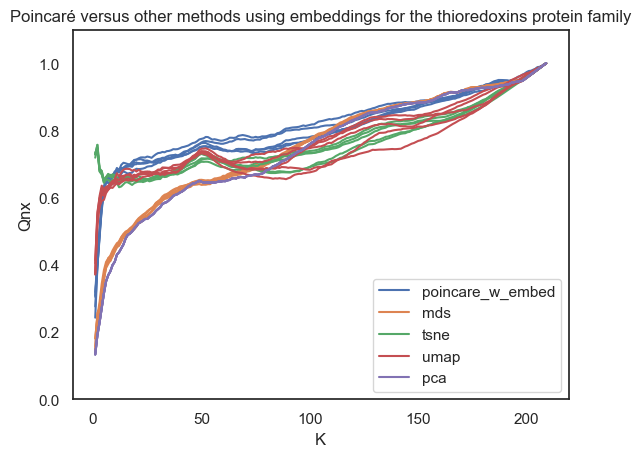

In [14]:
for clust_meth in ["poincare_w_embed", "mds", "tsne", "umap", "pca"]:
    Qnx_mean = []

    for seed in range(5):
        xx = df_results_proj[(df_results_proj.method==clust_meth)&(df_results_proj.seed==seed)].Qnx.values
        xx = xx.squeeze()[()]
        Qnx_mean.append(xx.mean())
        #print(len(xx))
        #fig = px.line(x = range(1,len(xx)+1), y= xx)
        if seed == 0:
            sns.lineplot(x = range(1,len(xx)+1), y = xx, color = meth_palette[clust_meth], label = clust_meth)
        else:
            sns.lineplot(x = range(1,len(xx)+1), y = xx, color = meth_palette[clust_meth])#, label = clust_meth)
    print(clust_meth, "%2.2f, %2.2f"%(np.mean(Qnx_mean), np.std(Qnx_mean)))

#plt.legend()
plt.xlabel("K")
plt.ylabel("Qnx")
plt.ylim([0,1.1])
plt.title('Poincaré versus other methods using embeddings for the thioredoxins protein family')
#plt.savefig("Qnx_global_kinases.pdf")
plt.show()

In [15]:
print("Local")
for clust_meth in ["poincare_w_embed", "mds", "tsne", "umap", "pca"]:
    print(clust_meth, "%2.2f, %2.2f"%(df_results_proj[(df_results_proj.method==clust_meth)].Qlocal.values.mean(), df_results_proj[(df_results_proj.method==clust_meth)].Qlocal.values.std()))
    
print("Global")   
for clust_meth in ["poincare_w_embed", "mds", "tsne", "umap", "pca"]:
    print(clust_meth, "%2.2f, %2.2f"%(df_results_proj[(df_results_proj.method==clust_meth)].Qglobal.values.mean(), df_results_proj[(df_results_proj.method==clust_meth)].Qglobal.values.std()))

Local
poincare_w_embed 0.58, 0.01
mds 0.47, 0.01
tsne 0.74, 0.00
umap 0.58, 0.03
pca 0.47, 0.00
Global
poincare_w_embed 0.82, 0.01
mds 0.81, 0.00
tsne 0.77, 0.01
umap 0.78, 0.02
pca 0.81, 0.00


## Evaluate clustering - poincaré vs other methods using poincaré

In [16]:
df_results_clust = pd.DataFrame()
df_results_proj = pd.DataFrame()

In [17]:
cname = 'agglomerative'
setting = "manifold" # "global" 


for seed in range(5):
    # read poincare and annotations
    path_embedding = f"{out_name_mfasta}/PM{knn:1.0f}sigma={sigma:2.2f}gamma={gamma:2.2f}cosinepca={cospca:1.0f}_seed{seed:1.0f}.csv"
    df_embedding = read_embeddings(path_embedding, path_annotation, withroot=False)
    df_embedding.replace("Other", "OTHER")
    # calculate poincare distances
    poincare_coord = df_embedding[["pm1","pm2"]]
    poincare_coord = poincare_coord.values
    #print(poincare_coord)
    model = PoincareMaps(poincare_coord)
    model.get_distances()
    # poincare scores
    clusters = detect_cluster(model.distances, n_clusters=nc, clustering_name=cname)
    df_embedding["clust_poincare"] = clusters
    df_embedding["clust_poincare"] = df_embedding["clust_poincare"].astype("string")
    # MDS scores
    X_cosine = pairwise_distances(features_mfasta,metric='cosine')
    X_mds = MDS(metric=True,dissimilarity='precomputed', random_state = seed).fit_transform(X_cosine)
    df_embedding["x1_mds"] = X_mds[:,0]
    df_embedding["x2_mds"] = X_mds[:,1]
    D = pairwise_distances(X_mds)
    clusters = detect_cluster(D, n_clusters=nc, clustering_name=cname)
    df_embedding["clust_mds"] = clusters
    df_embedding["clust_mds"] = df_embedding["clust_mds"].astype("string")
    # tSNE scores
    X_tsne = TSNE(random_state = seed, metric = "cosine", perplexity=k_neigh).fit_transform(features_mfasta)
    df_embedding["x1_tsne"] = X_tsne[:,0]
    df_embedding["x2_tsne"] = X_tsne[:,1]
    D = pairwise_distances(X_tsne)
    clusters = detect_cluster(D, n_clusters=nc, clustering_name=cname)
    df_embedding["clust_tsne"] = clusters
    df_embedding["clust_tsne"] = df_embedding["clust_tsne"].astype("string")
    # UMAP scores
    X_umap = umap.UMAP(random_state = seed, metric = "cosine", n_neighbors = k_neigh).fit_transform(features_mfasta)
    df_embedding["x1_umap"] = X_umap[:,0]
    df_embedding["x2_umap"] = X_umap[:,1]
    D = pairwise_distances(X_umap)
    clusters = detect_cluster(D, n_clusters=nc, clustering_name=cname)
    df_embedding["clust_umap"] = clusters
    df_embedding["clust_umap"] = df_embedding["clust_umap"].astype("string")
    # PCA scores
    X_pca = KernelPCA(kernel='cosine', random_state = seed).fit_transform(features_mfasta)
    df_embedding["x1_pca"] = X_pca[:,0]
    df_embedding["x2_pca"] = X_pca[:,1]
    D = pairwise_distances(X_pca)
    clusters = detect_cluster(D, n_clusters=nc, clustering_name=cname)#, k=15)
    df_embedding["clust_pca"] = clusters
    df_embedding["clust_pca"] = df_embedding["clust_pca"].astype("string")
    
    # clustering
    if remove_outliers:
        df_noothers = df_embedding[no_outliers]
    if remove_others:
        df_noothers = df_noothers[df_embedding[true_col]!=other]
    if not remove_outliers and not remove_others:
        df_noothers = df_embedding
    
    for clust_meth in ["poincare", "mds", "tsne", "umap", "pca"]:

        ARI, FMS = get_scores(df_noothers[true_col], df_noothers["clust_" + clust_meth])

        if clust_meth == "poincare":
            D = model.distances
            Qlocal, Qglobal, Kmax, df_Q = get_quality_metrics(coord_high = features_mfasta, coord_low = model.coordinates, distance="poincare", setting=setting, k_neighbours=5)
        else:
            D = pairwise_distances(df_embedding.loc[:, "x1_"+clust_meth:"x2_"+clust_meth])
            Qlocal, Qglobal, Kmax, df_Q = get_quality_metrics(coord_high = features_mfasta, coord_low = df_embedding.loc[:, "x1_"+clust_meth:"x2_"+clust_meth], distance="euclidean", setting=setting, k_neighbours=5)

        corr = scipy.stats.spearmanr(D_raw_mfasta.ravel(), D.ravel(), axis = 0)
    
        df = pd.DataFrame({"method": [clust_meth], "seed": [seed], "nc": [nc], "true_col": [true_col], "ARI": [ARI], "FMS": [FMS]})
        df_results_clust = pd.concat([df_results_clust, df])
        
        # print(df_Q.Qnx.to_numpy())
        
        df = pd.DataFrame({"method": [clust_meth], "seed": [seed], "Qlocal": [Qlocal], "Qglobal": [Qglobal], "Kmax": [Kmax], "Qnx": [df_Q.Qnx.to_numpy()]})
        df_results_proj = pd.concat([df_results_proj, df])


#print(df_results)

Connecting 3
Connecting 3
Connecting 3
Connecting 3
Connecting 3
Connecting 3
Connecting 3
Connecting 3
Connecting 3
Connecting 3
Connecting 3
Connecting 3
Connecting 3
Connecting 3
Connecting 3
Connecting 3
Connecting 3
Connecting 3
Connecting 3
Connecting 3
Connecting 3
Connecting 3
Connecting 3
Connecting 3
Connecting 3


### FMS

In [18]:
fig = px.strip(df_results_clust, x='method', y='FMS', color = "true_col")
fig.update_yaxes(range = [0,1])
fig.show()

# Need to add the original poincaré method

### Qnx

In [19]:
print(sns.color_palette(palette=None, n_colors=5).as_hex())
meth_palette = dict(zip(["poincare", "mds", "tsne", "umap", "pca"], sns.color_palette(palette=None, n_colors=5).as_hex()))
print(meth_palette)

['#4c72b0', '#dd8452', '#55a868', '#c44e52', '#8172b3']
{'poincare': '#4c72b0', 'mds': '#dd8452', 'tsne': '#55a868', 'umap': '#c44e52', 'pca': '#8172b3'}


poincare 0.77, 0.00
mds 0.67, 0.00
tsne 0.71, 0.01
umap 0.71, 0.00
pca 0.62, 0.00


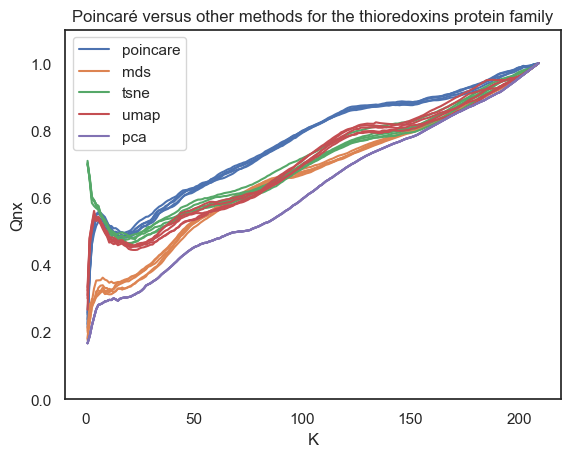

In [20]:
for clust_meth in ["poincare", "mds", "tsne", "umap", "pca"]:
    Qnx_mean = []

    for seed in range(5):
        xx = df_results_proj[(df_results_proj.method==clust_meth)&(df_results_proj.seed==seed)].Qnx.values
        xx = xx.squeeze()[()]
        Qnx_mean.append(xx.mean())
        #print(len(xx))
        #fig = px.line(x = range(1,len(xx)+1), y= xx)
        if seed == 0:
            sns.lineplot(x = range(1,len(xx)+1), y = xx, color = meth_palette[clust_meth], label = clust_meth)
        else:
            sns.lineplot(x = range(1,len(xx)+1), y = xx, color = meth_palette[clust_meth])#, label = clust_meth)
    print(clust_meth, "%2.2f, %2.2f"%(np.mean(Qnx_mean), np.std(Qnx_mean)))

#plt.legend()
plt.xlabel("K")
plt.ylabel("Qnx")
plt.ylim([0,1.1])
plt.title('Poincaré versus other methods for the thioredoxins protein family')
#plt.savefig("Qnx_global_kinases.pdf")
plt.show()

## Poincaré with and without embedding comparison

In [21]:
df_results_clust = pd.DataFrame()
df_results_proj = pd.DataFrame()

In [22]:
cname = 'agglomerative'
setting = "manifold" # "global" 


for seed in range(5):

    # Read regular poincaré
    path_embedding = f"{out_name_mfasta}/PM{knn:1.0f}sigma={sigma:2.2f}gamma={gamma:2.2f}cosinepca={cospca:1.0f}_seed{seed:1.0f}.csv"
    df_embedding = read_embeddings(path_embedding, path_annotation, withroot=False)
    df_embedding.replace("Other", "OTHER")
    # calculate poincare distances
    poincare_coord = df_embedding[["pm1","pm2"]]
    poincare_coord = poincare_coord.values
    #print(poincare_coord)
    model_a = PoincareMaps(poincare_coord)
    model_a.get_distances()
    # poincare scores
    clusters = detect_cluster(model_a.distances, n_clusters=nc, clustering_name=cname)
    df_embedding["poincare"] = clusters
    df_embedding["poincare"] = df_embedding["poincare"].astype("string")
    
    # Read regular poincaré
    path_embedding = f"{out_name_embed}/PM{knn:1.0f}sigma={sigma:2.2f}gamma={gamma:2.2f}cosinepca={cospca:1.0f}_seed{seed:1.0f}.csv"
    new_df = read_embeddings(path_embedding, path_annotation, withroot=False)
    new_df.replace("Other", "OTHER")
    # calculate poincare distances
    poincare_coord = new_df[["pm1","pm2"]]
    poincare_coord = poincare_coord.values
    #print(poincare_coord)
    model_b = PoincareMaps(poincare_coord)
    model_b.get_distances()
    # poincare scores
    clusters = detect_cluster(model_b.distances, n_clusters=nc, clustering_name=cname)
    df_embedding["poincare_w_embed (cosine y=2)"] = clusters
    df_embedding["poincare_w_embed (cosine y=2)"] = df_embedding["poincare_w_embed (cosine y=2)"].astype("string")

    # Read regular poincaré
    path_embedding = f"{out_name_embed}/PM{knn:1.0f}sigma={sigma:2.2f}gamma={gamma:2.2f}minkowskipca={cospca:1.0f}_seed{seed:1.0f}.csv"
    new_df = read_embeddings(path_embedding, path_annotation, withroot=False)
    new_df.replace("Other", "OTHER")
    # calculate poincare distances
    poincare_coord = new_df[["pm1","pm2"]]
    poincare_coord = poincare_coord.values
    #print(poincare_coord)
    model_c = PoincareMaps(poincare_coord)
    model_c.get_distances()
    # poincare scores
    clusters = detect_cluster(model_c.distances, n_clusters=nc, clustering_name=cname)
    df_embedding["poincare_w_embed (euclidean y=2)"] = clusters
    df_embedding["poincare_w_embed (euclidean y=2)"] = df_embedding["poincare_w_embed (euclidean y=2)"].astype("string")

    # Read regular poincaré
    path_embedding = f"{out_name_embed}/PM{knn:1.0f}sigma={sigma:2.2f}gamma={gamma + 2:2.2f}cosinepca={cospca:1.0f}_seed{seed:1.0f}.csv"
    new_df = read_embeddings(path_embedding, path_annotation, withroot=False)
    new_df.replace("Other", "OTHER")
    # calculate poincare distances
    poincare_coord = new_df[["pm1","pm2"]]
    poincare_coord = poincare_coord.values
    #print(poincare_coord)
    model_d = PoincareMaps(poincare_coord)
    model_d.get_distances()
    # poincare scores
    clusters = detect_cluster(model_d.distances, n_clusters=nc, clustering_name=cname)
    df_embedding["poincare_w_embed (cosine y=4)"] = clusters
    df_embedding["poincare_w_embed (cosine y=4)"] = df_embedding["poincare_w_embed (cosine y=4)"].astype("string")

    # Read regular poincaré
    path_embedding = f"{out_name_embed}/PM{knn:1.0f}sigma={sigma:2.2f}gamma={gamma + 2:2.2f}minkowskipca={cospca:1.0f}_seed{seed:1.0f}.csv"
    new_df = read_embeddings(path_embedding, path_annotation, withroot=False)
    new_df.replace("Other", "OTHER")
    # calculate poincare distances
    poincare_coord = new_df[["pm1","pm2"]]
    poincare_coord = poincare_coord.values
    #print(poincare_coord)
    model_e = PoincareMaps(poincare_coord)
    model_e.get_distances()
    # poincare scores
    clusters = detect_cluster(model_e.distances, n_clusters=nc, clustering_name=cname)
    df_embedding["poincare_w_embed (euclidean y=4)"] = clusters
    df_embedding["poincare_w_embed (euclidean y=4)"] = df_embedding["poincare_w_embed (euclidean y=4)"].astype("string")
    
    
    # clustering
    if remove_outliers:
        df_noothers = df_embedding[no_outliers]
    if remove_others:
        df_noothers = df_noothers[df_embedding[true_col]!=other]
    if not remove_outliers and not remove_others:
        df_noothers = df_embedding

    conditions = ["poincare", "poincare_w_embed (cosine y=2)", "poincare_w_embed (euclidean y=2)", 
                       "poincare_w_embed (cosine y=4)", "poincare_w_embed (euclidean y=4)"]
    models = [model_a, model_b, model_c, model_d, model_e]
    feature_set = [features_mfasta, features_embed, features_embed, features_embed, features_embed]
    distances = [D_raw_mfasta, D_raw_embed, D_raw_embed, D_raw_embed, D_raw_embed]
    
    for clust_meth, model, chosen_feature, d_raw in zip(conditions, models, feature_set, distances):

        ARI, FMS = get_scores(df_noothers[true_col], df_noothers[f"{clust_meth}"])

        D = model.distances
        Qlocal, Qglobal, Kmax, df_Q = get_quality_metrics(coord_high = chosen_feature, coord_low = model.coordinates, distance="poincare", setting=setting, k_neighbours=5)

        corr = scipy.stats.spearmanr(d_raw.ravel(), D.ravel(), axis = 0)
    
        df = pd.DataFrame({"method": [clust_meth], "seed": [seed], "nc": [nc], "true_col": [true_col], "ARI": [ARI], "FMS": [FMS]})
        df_results_clust = pd.concat([df_results_clust, df])
        
        # print(df_Q.Qnx.to_numpy())
        
        df = pd.DataFrame({"method": [clust_meth], "seed": [seed], "Qlocal": [Qlocal], "Qglobal": [Qglobal], "Kmax": [Kmax], "Qnx": [df_Q.Qnx.to_numpy()]})
        df_results_proj = pd.concat([df_results_proj, df])


#print(df_results)

Connecting 3
Connecting 2
Connecting 2
Connecting 2
Connecting 2
Connecting 3
Connecting 2
Connecting 2
Connecting 2
Connecting 2
Connecting 3
Connecting 2
Connecting 2
Connecting 2
Connecting 2
Connecting 3
Connecting 2
Connecting 2
Connecting 2
Connecting 2
Connecting 3
Connecting 2
Connecting 2
Connecting 2
Connecting 2


In [23]:
print(df_results_proj.head(20))

                             method  seed    Qlocal   Qglobal  Kmax  \
0                          poincare     0  0.446310  0.772998     5   
0     poincare_w_embed (cosine y=2)     0  0.575891  0.835990    10   
0  poincare_w_embed (euclidean y=2)     0  0.571560  0.839362    12   
0     poincare_w_embed (cosine y=4)     0  0.578864  0.821143    10   
0  poincare_w_embed (euclidean y=4)     0  0.610116  0.834589    20   
0                          poincare     1  0.434063  0.777176     4   
0     poincare_w_embed (cosine y=2)     1  0.572505  0.825200     9   
0  poincare_w_embed (euclidean y=2)     1  0.590592  0.831828    14   
0     poincare_w_embed (cosine y=4)     1  0.524796  0.779489     8   
0  poincare_w_embed (euclidean y=4)     1  0.557118  0.824861    12   
0                          poincare     2  0.453704  0.773834     5   
0     poincare_w_embed (cosine y=2)     2  0.582288  0.816440    10   
0  poincare_w_embed (euclidean y=2)     2  0.566216  0.818326    12   
0     

### FMS

In [24]:
fig = px.strip(df_results_clust, x='method', y='FMS', color = "true_col")
fig.update_yaxes(range = [0,1])
fig.show()

# Need to add the original poincaré method

### Qnx

In [25]:
print(sns.color_palette(palette=None, n_colors=5).as_hex())
meth_palette = dict(zip(conditions, sns.color_palette(palette=None, n_colors=5).as_hex()))
print(meth_palette)

['#4c72b0', '#dd8452', '#55a868', '#c44e52', '#8172b3']
{'poincare': '#4c72b0', 'poincare_w_embed (cosine y=2)': '#dd8452', 'poincare_w_embed (euclidean y=2)': '#55a868', 'poincare_w_embed (cosine y=4)': '#c44e52', 'poincare_w_embed (euclidean y=4)': '#8172b3'}


poincare 0.77, 0.00
poincare_w_embed (cosine y=2) 0.81, 0.01
poincare_w_embed (euclidean y=2) 0.81, 0.01
poincare_w_embed (cosine y=4) 0.80, 0.01
poincare_w_embed (euclidean y=4) 0.80, 0.01


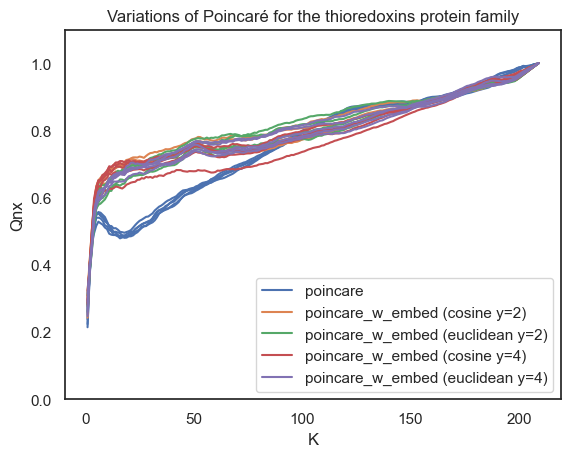

In [26]:
for clust_meth in conditions:
    Qnx_mean = []

    for seed in range(5):
        xx = df_results_proj[(df_results_proj.method==clust_meth)&(df_results_proj.seed==seed)].Qnx.values
        xx = xx.squeeze()[()]
        Qnx_mean.append(xx.mean())
        #print(len(xx))
        #fig = px.line(x = range(1,len(xx)+1), y= xx)
        if seed == 0:
            sns.lineplot(x = range(1,len(xx)+1), y = xx, color = meth_palette[clust_meth], label = clust_meth)
        else:
            sns.lineplot(x = range(1,len(xx)+1), y = xx, color = meth_palette[clust_meth])#, label = clust_meth)
    print(clust_meth, "%2.2f, %2.2f"%(np.mean(Qnx_mean), np.std(Qnx_mean)))

#plt.legend()
plt.xlabel("K")
plt.ylabel("Qnx")
plt.ylim([0,1.1])
plt.title('Variations of Poincaré for the thioredoxins protein family')
#plt.savefig("Qnx_global_kinases.pdf")
plt.show()

In [24]:
print("Local")
for clust_meth in ["poincare", "mds", "tsne", "umap", "pca"]:
    print(clust_meth, "%2.2f, %2.2f"%(df_results_proj[(df_results_proj.method==clust_meth)].Qlocal.values.mean(), df_results_proj[(df_results_proj.method==clust_meth)].Qlocal.values.std()))
    
print("Global")   
for clust_meth in ["poincare", "mds", "tsne", "umap", "pca"]:
    print(clust_meth, "%2.2f, %2.2f"%(df_results_proj[(df_results_proj.method==clust_meth)].Qglobal.values.mean(), df_results_proj[(df_results_proj.method==clust_meth)].Qglobal.values.std()))

Local
poincare 0.30, 0.00
mds 0.26, 0.01
tsne 0.32, 0.00
umap 0.31, 0.01
pca 0.31, 0.00
Global
poincare 0.59, 0.00
mds 0.62, 0.00
tsne 0.62, 0.00
umap 0.63, 0.02
pca 0.58, 0.00


# 
# 
# 

### Poincaré distances hyperboliques 

In [24]:
for cname in ['agglomerative']:#, 'spectral']:#, 'agglomerative', 'kmedoids']:
    clusters = detect_cluster(model.distances, n_clusters=nc, clustering_name=cname)#, k=15)
    df_embedding["clust_poincare"] = clusters
    df_embedding["clust_poincare"] = df_embedding["clust_poincare"].astype("string")

### MDS

In [25]:
X_cosine = pairwise_distances(features,metric='cosine')
X_mds = MDS(metric=True,dissimilarity='precomputed', random_state = seed).fit_transform(X_cosine)
df_embedding["x1_mds"] = X_mds[:,0]
df_embedding["x2_mds"] = X_mds[:,1]

In [26]:
D = pairwise_distances(X_mds)
print(D.shape)

for cname in ['agglomerative']:#,'spectral']:#, 'agglomerative', 'kmedoids']:
    clusters = detect_cluster(D, n_clusters=nc, clustering_name=cname)#, k=15)
    df_embedding["clust_mds"] = clusters
    df_embedding["clust_mds"] = df_embedding["clust_mds"].astype("string")

(204, 204)


### t-SNE

In [27]:
X_tsne = TSNE(random_state = seed, metric = "cosine", perplexity=k_neigh).fit_transform(features)
df_embedding["x1_tsne"] = X_tsne[:,0]
df_embedding["x2_tsne"] = X_tsne[:,1]

In [28]:
D = pairwise_distances(X_tsne)

for cname in ['agglomerative']:#, 'spectral']:#, 'agglomerative', 'kmedoids']:
    clusters = detect_cluster(D, n_clusters=nc, clustering_name=cname)#, k=15)
    df_embedding["clust_tsne"] = clusters
    df_embedding["clust_tsne"] = df_embedding["clust_tsne"].astype("string")

### UMAP

In [29]:
X_umap = umap.UMAP(random_state = seed, metric = "cosine", n_neighbors = k_neigh).fit_transform(features)
df_embedding["x1_umap"] = X_umap[:,0]
df_embedding["x2_umap"] = X_umap[:,1]

In [30]:
D = pairwise_distances(X_umap)
print(D.shape)

for cname in ['agglomerative']:#, 'spectral']:#, 'agglomerative', 'kmedoids']:
    clusters = detect_cluster(D, n_clusters=nc, clustering_name=cname)#, k=15)
    df_embedding["clust_umap"] = clusters
    df_embedding["clust_umap"] = df_embedding["clust_umap"].astype("string")

(204, 204)


### PCA

In [31]:
X_pca = KernelPCA(kernel='cosine', random_state = seed).fit_transform(features)
df_embedding["x1_pca"] = X_pca[:,0]
df_embedding["x2_pca"] = X_pca[:,1]

In [32]:
D = pairwise_distances(X_pca)
print(D.shape)


for cname in ['agglomerative']:#, 'spectral']:#, 'agglomerative', 'kmedoids']:
    clusters = detect_cluster(D, n_clusters=nc, clustering_name=cname)#, k=15)
    df_embedding["clust_pca"] = clusters
    df_embedding["clust_pca"] = df_embedding["clust_pca"].astype("string")

(204, 204)


## Compare scores for clustering

In [35]:
if remove_outliers:
    df_noothers = df_embedding[no_outliers]
if remove_others:
    df_noothers = df_noothers[df_embedding[true_col]!=other]
        
print(df_embedding.shape, df_noothers.shape)

for clust_meth in ["poincare", "mds", "tsne", "umap", "pca"]:

    ARI, FMS = get_scores(df_noothers[true_col], df_noothers["clust_" + clust_meth])

    if clust_meth == "poincare":
        D = model.distances
        Qlocal, Qglobal, Kmax, df_Q = get_quality_metrics(coord_high = features, coord_low = model.coordinates, distance="poincare", setting="manifold", k_neighbours=5)
    else:
        D = pairwise_distances(df_embedding.loc[:, "x1_"+clust_meth:"x2_"+clust_meth])
        Qlocal, Qglobal, Kmax, df_Q = get_quality_metrics(coord_high = features, coord_low = df_embedding.loc[:, "x1_"+clust_meth:"x2_"+clust_meth], distance="euclidean", setting="manifold", k_neighbours=5)

    corr = scipy.stats.spearmanr(D_raw.ravel(), D.ravel(), axis = 0)
    
    df = pd.DataFrame({"method": [clust_meth], "seed": [seed], "Qlocal": [Qlocal], "Qglobal": [Qglobal], "true_col": [true_col], "ARI": [ARI], "FMS": [FMS]})
    df_results = df
    print(clust_meth + ": " + f"{ARI:.2f} " + f"{FMS:.2f} " + f"{corr.correlation:.2f} " + f"{Qlocal:.2f} "+f"{Qglobal:.2f} ")
#print(scipy.stats.spearmanr(D_raw.ravel(), D.ravel(), axis = 0))

(204, 18) (202, 18)
Connecting 6
poincare: 0.01 0.22 0.07 0.32 0.82 
Connecting 6
mds: 0.02 0.28 0.88 0.53 0.77 
Connecting 6
tsne: 0.01 0.23 0.45 0.82 0.71 
Connecting 6
umap: 0.03 0.30 0.53 0.64 0.72 
Connecting 6
pca: 0.01 0.24 0.58 0.49 0.71 


In [36]:
print(df_results)

  method  seed    Qlocal   Qglobal true_col       ARI       FMS
0    pca     4  0.486248  0.711172    label  0.008443  0.242526


In [37]:
clust_meth = "tsne"
k_neigh = 5
X_tsne = TSNE(random_state = seed, metric = "cosine", perplexity=k_neigh).fit_transform(features)
df_embedding["x1_tsne"] = X_tsne[:,0]
df_embedding["x2_tsne"] = X_tsne[:,1]
Qlocalt, Qglobalt, Kmaxt, df_q = get_quality_metrics(coord_high = features, coord_low = df_embedding.loc[:, "x1_"+clust_meth:"x2_"+clust_meth], distance="euclidean", setting="manifold", k_neighbours=5, my_metric = "cosine")
print(Qlocalt, Qglobalt)

Connecting 6
0.8235294117647058 0.7106518366473186


In [38]:
df_q

,Qnx,Bnx
0,0.823529,0.000000
1,0.791667,0.007353
2,0.785948,0.011438
3,0.786765,0.024510
4,0.789216,0.022549
...,...,...
198,0.981082,0.055646
199,0.986152,0.055343
200,0.990050,0.053922
201,0.995050,0.053655


In [39]:
clust_meth = "umap"
k_neigh = 5
X_umap = umap.UMAP(random_state = seed, metric = "cosine", n_neighbors = k_neigh).fit_transform(features)
df_embedding["x1_umap"] = X_umap[:,0]
df_embedding["x2_umap"] = X_umap[:,1]
Qlocal, Qglobal, Kmax, df_qumap = get_quality_metrics(coord_high = features, coord_low = df_embedding.loc[:, "x1_"+clust_meth:"x2_"+clust_meth], distance="euclidean", setting="manifold", k_neighbours=5)
print(Qlocal, Qglobal)

Connecting 6
0.6420547385620915 0.7236404564034712


In [40]:
df_qumap

,Qnx,Bnx
0,0.524510,0.000000
1,0.610294,0.036765
2,0.699346,0.055556
3,0.734069,0.051471
4,0.714706,0.049020
...,...,...
198,0.979899,0.079269
199,0.985000,0.078873
200,0.990050,0.078480
201,0.995050,0.078092


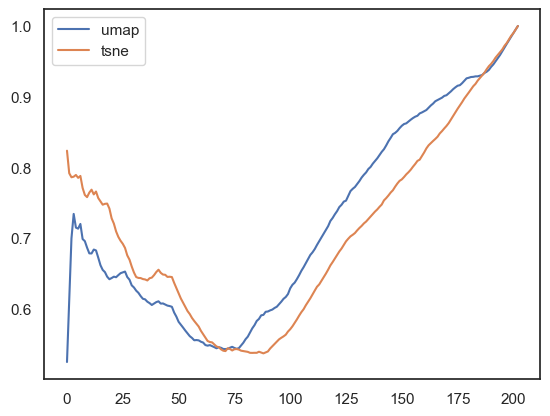

In [41]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(df_qumap.Qnx, label="umap")
plt.plot(df_q.Qnx, label = "tsne")
plt.legend()
plt.show()

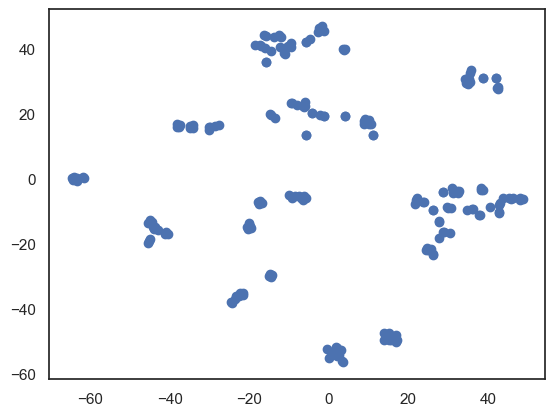

In [42]:
plt.scatter(X_tsne[:,0], X_tsne[:,1])

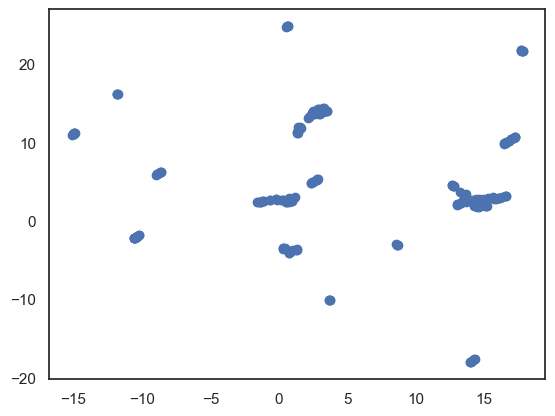

In [43]:
plt.scatter(X_umap[:,0], X_umap[:,1])

In [45]:
poincare_coord = pd.read_csv(path_embedding, sep=',').sort_values(by=["proteins_id"])
poincare_coord = poincare_coord.values[:,:2]
poincare_coord = np.array(poincare_coord, dtype = np.float64)

model = PoincareMaps(poincare_coord)
model.get_distances()
clust_meth = "poincare"
k_neigh = 5
Qlocalp, Qglobalp, Kmaxp, df_qumapoin = get_quality_metrics(coord_high = features, coord_low = model.coordinates, distance="poincare", setting="manifold", k_neighbours=5)
print(Qlocalp, Qglobalp)

Connecting 6
0.3216144123830685 0.8192309187188455


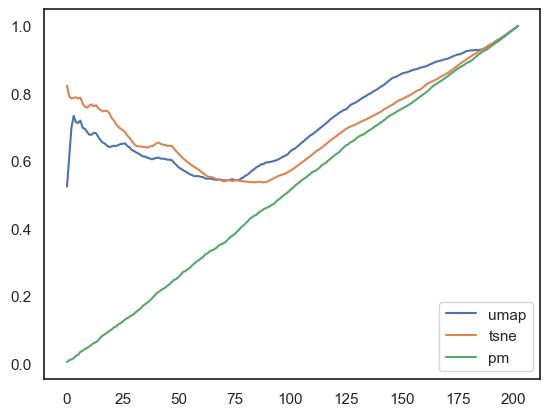

In [46]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(df_qumap.Qnx, label="umap")
plt.plot(df_q.Qnx, label = "tsne")
plt.plot(df_qumapoin.Qnx, label="pm")
plt.legend()

In [47]:
print(Qlocal, Qglobal)
print(Qlocalt, Qglobalt)

0.6420547385620915 0.7236404564034712
0.8235294117647058 0.7106518366473186


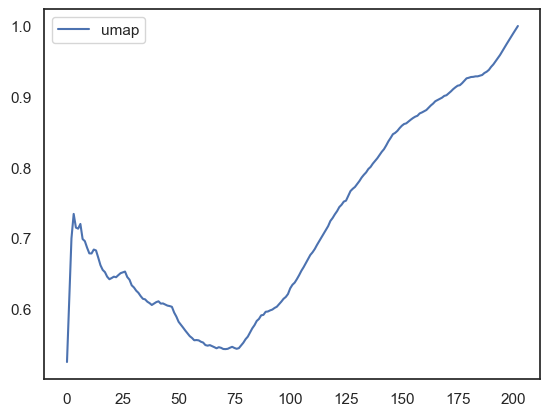

In [48]:

plt.plot(df_qumap.Qnx, label="umap")
plt.legend()

In [49]:
fig = px.strip(df_results, x='method', y='ARI', color = "true_col")
fig.show()

In [50]:
fig = px.strip(df_results, x='method', y='FMS', color = "true_col")
fig.show()

In [51]:
fig = px.strip(df_results[df_results.true_col=="tree1"], x='method', y=['corr'])
fig.show()

In [52]:
fig = px.strip(df_results[df_results.true_col=="tree1"], x='method', y=['Qglobal'])
fig.show()

In [53]:
fig = px.strip(df_results[df_results.true_col=="tree1"], x='method', y=['Qlocal'])
fig.show()

# Plots

## PoincaréMSA

In [54]:
fig = plot_embedding_interactive(df_embedding, 
                                 labels_name = "clust_poincare",
                                 #second_labels_name = second_labels_name, 
                                 #show_text = show_text,
                                 #labels_text = labels_text,
                                 color_palette = None,
                                 #color_discrete_sequence = px.colors.qualitative.Alphabet,
                                 #color_discrete_map=phosphatase_cols,
                                 #title = title, 
                                 fontsize = 11)
fig.show()


        #        scores.append(s)
#        titles.append(t)

#for cname in ['spectral', 'agglomerative', 'kmedoids']:
 #       s, t = detect_cluster(model.get_distances(), 
  #                            n_clusters=nc, clustering_name=cname, k=15, distances='raw')
        #scores.append(s)
        #titles.append(t)

## MDS

In [ ]:
plt = px.scatter(df_embedding, x = 'x1_mds', y = 'x2_mds',
                    color = df_embedding["clust_mds"],
                    color_discrete_sequence = px.colors.qualitative.Alphabet,
                    color_discrete_map=thioredoxins_cols,
                    #color_continuous_scale = "Turbo",
                    ##labels={'color': labels}, 
                    #hover_name=labels_name,
                    #hover_data=df.columns[2:],
                    #height = 800,
                    #title = title,
                )
plt.update_xaxes(range = [-0.7, 0.7], constrain="domain")
plt.update_yaxes(range = [-0.7, 0.7], constrain="domain")

plt.update_yaxes(scaleanchor = "x", scaleratio = 1)
plt.show()

plt = px.scatter(df_embedding, x = 'x1_mds', y = 'x2_mds',
                    color = df_embedding[true_col],
                    color_discrete_sequence = px.colors.qualitative.Alphabet,
                    color_discrete_map=phosphatase_cols,
                    #color_continuous_scale = "Turbo",
                    ##labels={'color': labels}, 
                    #hover_name=labels_name,
                    #hover_data=df.columns[2:],
                    #height = 800,
                    #title = title,
                )
plt.update_xaxes(range = [-0.7, 0.7], constrain="domain")
plt.update_yaxes(range = [-0.7, 0.7], constrain="domain")

plt.update_yaxes(scaleanchor = "x", scaleratio = 1)
plt.show()

## tSNE

In [56]:

plt = px.scatter(df_embedding, x = 'x1_tsne', y = 'x2_tsne',
                    color = df_embedding["clust_tsne"],
                    color_discrete_sequence = px.colors.qualitative.Alphabet,
                    color_discrete_map=phosphatase_cols,
                    #color_continuous_scale = "Turbo",
                    ##labels={'color': labels}, 
                    #hover_name=labels_name,
                    #hover_data=df.columns[2:],
                    #height = 800,
                    #title = title,
                )
#plt.update_xaxes(range = [-10 50], constrain="domain")
#plt.update_yaxes(range = [-0.5, 0.5], constrain="domain")

plt.update_yaxes(scaleanchor = "x", scaleratio = 1)
plt.show()

plt = px.scatter(df_embedding, x = 'x1_tsne', y = 'x2_tsne',
                    color = df_embedding[true_col],
                    color_discrete_sequence = px.colors.qualitative.Alphabet,
                    color_discrete_map=phosphatase_cols,
                    #color_continuous_scale = "Turbo",
                    ##labels={'color': labels}, 
                    #hover_name=labels_name,
                    #hover_data=df.columns[2:],
                    #height = 800,
                    #title = title,
                )
#plt.update_xaxes(range = [-60, 50], constrain="domain")
#plt.update_yaxes(range = [-0.5, 0.5], constrain="domain")

plt.update_yaxes(scaleanchor = "x", scaleratio = 1)
plt.show()

## UMAP

In [57]:
plt = px.scatter(df_embedding, x = 'x1_umap', y = 'x2_umap',
                    color = df_embedding["clust_umap"],
                    color_discrete_sequence = px.colors.qualitative.Alphabet,
                    color_discrete_map=phosphatase_cols,
                    #color_continuous_scale = "Turbo",
                    ##labels={'color': labels}, 
                    #hover_name=labels_name,
                    #hover_data=df.columns[2:],
                    #height = 800,
                    #title = title,
                )
#plt.update_xaxes(range = [-10 50], constrain="domain")
#plt.update_yaxes(range = [-0.5, 0.5], constrain="domain")

plt.update_yaxes(scaleanchor = "x", scaleratio = 1)
plt.show()

plt = px.scatter(df_embedding, x = 'x1_umap', y = 'x2_umap',
                    color = df_embedding[true_col],
                    color_discrete_sequence = px.colors.qualitative.Alphabet,
                    color_discrete_map=phosphatase_cols,
                    #color_continuous_scale = "Turbo",
                    ##labels={'color': labels}, 
                    #hover_name=labels_name,
                    #hover_data=df.columns[2:],
                    #height = 800,
                    #title = title,
                )
#plt.update_xaxes(range = [-60, 50], constrain="domain")
#plt.update_yaxes(range = [-0.5, 0.5], constrain="domain")

plt.update_yaxes(scaleanchor = "x", scaleratio = 1)
plt.show()

## PCA

In [58]:
plt = px.scatter(df_embedding, x = 'x1_pca', y = 'x2_pca',
                    color = df_embedding["clust_pca"],
                    color_discrete_sequence = px.colors.qualitative.Alphabet,
                    color_discrete_map=phosphatase_cols,
                    #color_continuous_scale = "Turbo",
                    ##labels={'color': labels}, 
                    #hover_name=labels_name,
                    #hover_data=df.columns[2:],
                    #height = 800,
                    #title = title,
                )


plt.update_yaxes(scaleanchor = "x", scaleratio = 1)
plt.show()

In [59]:

    
plt = px.scatter(df_embedding, x = 'x1_pca', y = 'x2_pca',
                     color = df_embedding[true_col],
                     color_discrete_sequence = px.colors.qualitative.Alphabet,
                     color_discrete_map=phosphatase_cols,
                     #color_continuous_scale = "Turbo",
                     ##labels={'color': labels}, 
                     #hover_name=labels_name,
                     #hover_data=df.columns[2:],
                     #height = 800,
                     #title = title,
                 )
#plt.update_xaxes(range = [-60, 50], constrain="domain")
#plt.update_yaxes(range = [-0.5, 0.5], constrain="domain")

plt.update_yaxes(scaleanchor = "x", scaleratio = 1)
plt.show()